<a href="https://colab.research.google.com/github/pratik-walawalkar/tornaGAN/blob/main/Gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Include modules**

In [ ]:
!pip install -U tensorboard

In [ ]:
!pip install tensorflow==2.4.1


In [24]:
from IPython.display import Image 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2 as cv 
import argparse
import random
import glob
import time
import os
print("TensorFlow Version: " + tf.__version__)
#tf.compat.v1.disable_eager_execution()

TensorFlow Version: 2.4.1


Variables

In [25]:
mode = "train"
batch_size = 1

Display Image Samples in the dataset

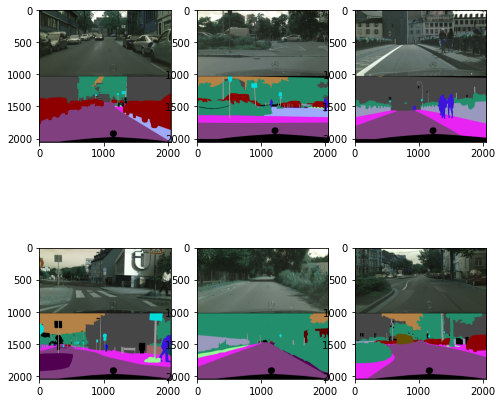

In [28]:
input_dir = r"/content/drive/MyDrive/Colab Datasets/cityscapes/combined/"
w = 5
h = 5
fig = plt.figure(figsize=(8,8))
col = 3
rows = 2
for i in range(1, col*rows +1):
  images = os.listdir(input_dir)
  sample = np.random.choice(images)
  image = cv.imread(os.path.join(input_dir, sample))
  fig.add_subplot(rows, col, i)
  plt.imshow(image)
plt.show()

In [30]:
def load(image_file):
  print(image_file)
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  h = tf.shape(image)[1]

  h = h // 2
  real_image = image[:h, :, :]
  input_image = image[h:, :, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

/content/drive/MyDrive/Colab Datasets/cityscapes/combined/darmstadt_000062_000019.png


NotImplementedError: ignored

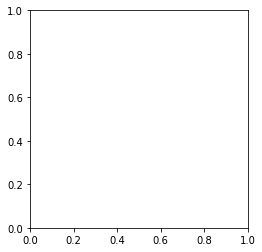

In [31]:
images = os.listdir(input_dir)
sample = np.random.choice(images)
#image = cv.imread(os.path.join(input_dir, sample))
inp, tar = load(os.path.join(input_dir, sample))


plt.figure()
plt.imshow(inp/255.0)

plt.figure()
plt.imshow(tar/255.0)

Resize Images

In [1]:
def resize(input_image, target_image, height=256, width=256):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  target_image = tf.image.resize(target_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, target_image

`Pre-process image (Normalize)

In [2]:
def normalize(input_image, target_image):
  with tf.name_scope("preprocess"):
      # [0, 1] => [-1, 1]
      return input_image * 2 - 1, target_image * 2 - 1

Loading Images

In [3]:
def load_image_train(image_file):
  input_image, target_image = load(image_file)
  input_image, target_image = normalize(input_image, target_image)

  return input_image, real_image

In [5]:
input_paths = glob.glob(os.path.join(input_dir + "*.png"))
dataset = tf.data.Dataset.list_files(input_paths)
dataset = dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

NameError: ignored

In [44]:
def dataloader():
  input_paths = glob.glob(os.path.join(input_dir, "*.png"))
  decode = tf.image.decode_png
  batch_size = 50
  def get_name(path):
    name, _ = os.path.splitext(os.path.basename(path))
    return get_name
  
  input_paths = sorted(input_paths)

  def preprocess(image):
    with tf.name_scope("preprocess"):
        # [0, 1] => [-1, 1]
        return image * 2 - 1

  dataset = tf.data.Dataset.list_files(input_paths)
  dataset = dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

  with tf.name_scope("load_images"):
    reader = tf.compat.v1.WholeFileReader()
    path_queue = tf.compat.v1.train.string_input_producer(input_paths, shuffle = "True")
    paths, contents = reader.read(path_queue)
    raw_input = decode(contents)
    raw_input = tf.image.convert_image_dtype(raw_input, dtype = tf.float32)

    assertion = tf.assert_equal(tf.shape(raw_input)[2], 3, message = "Image doesnot have three channels")
    with tf.control_dependencies([assertion]):
        raw_input = tf.identity(raw_input)

    raw_input.set_shape([None, None, 3])

    # break apart image pair and move to range [-1, 1]
    height = tf.shape(raw_input)[0] # [height, width, channels]
    a_images = preprocess(raw_input[:height//2, :,:])
    b_images = preprocess(raw_input[height//2:, :,:])

  inputs, targets = [b_images, a_images]

  input_images = tf.cast(inputs, tf.float32)
  target_images = tf.cast(targets, tf.float32)

  '''
  plt.figure()
  plt.imshow(inputs/255.0)
  plt.figure()
  plt.imshow(targets/255.0)
  '''

  paths_batch, inputs_batch, targets_batch = tf.compat.v1.train.batch([paths, input_images, target_images], batch_size=batch_size)
  steps_per_epoch = int(math.ceil(len(input_paths) / batch_size))

  return Examples(
      paths=paths_batch,
      inputs=inputs_batch,
      targets=targets_batch,
      count=len(input_paths),
      steps_per_epoch=steps_per_epoch,
  )
dataloader()

ValueError: ignored

In [20]:
dataloader()

AttributeError: ignored

Leaky ReLu Function

In [ ]:
def lrelu(x, a):
    with tf.name_scope("lrelu"):
        x = tf.identity(x)
        return (0.5 * (1 + a)) * x + (0.5 * (1 - a)) * tf.abs(x)

Downsample

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

UpSample

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

Generator Network

In [ ]:
def generator(generator_inputs, generator_outputs_channels):
    layers = []
    hidden_dim = "64"
    # layer_1: [batch, 256, 256, in_channels] => [batch, 128, 128, hidden_dim]
    with tf.variable_scope("layer_1"):
        output = downsample(generator_inputs, hidden_dim)
        layers.append(output)

  down_stack = [
    downsample(hidden_dim * 2, 4), # layer_2: [batch, 128, 128, hidden_dim] => [batch, 64, 64, hidden_dim * 2]
    downsample(hidden_dim * 4, 4), # layer_3: [batch, 64, 64, hidden_dim * 2] => [batch, 32, 32, hidden_dim * 4]
    downsample(hidden_dim * 8, 4), # layer_4: [batch, 32, 32, hidden_dim * 4] => [batch, 16, 16, hidden_dim * 8]
    downsample(hidden_dim * 8, 4), # layer_5: [batch, 16, 16, hidden_dim * 8] => [batch, 8, 8, hidden_dim * 8]
    downsample(hidden_dim * 8, 4), # layer_6: [batch, 8, 8, hidden_dim * 8] => [batch, 4, 4, hidden_dim * 8]
    downsample(hidden_dim * 8, 4), # layer_7: [batch, 4, 4, hidden_dim * 8] => [batch, 2, 2, hidden_dim * 8]
    downsample(hidden_dim * 8, 4), # layer_8: [batch, 2, 2, hidden_dim * 8] => [batch, 1, 1, hidden_dim * 8]
  ]

  up_stack = [
    upsample(hidden_dim * 8, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(hidden_dim * 8, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(hidden_dim * 8, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(hidden_dim * 8, 4), # (bs, 16, 16, 1024)
    upsample(hidden_dim * 4, 4), # (bs, 32, 32, 512)
    upsample(hidden_dim * 2, 4), # (bs, 64, 64, 256)
    upsample(hidden_dim, 4), # (bs, 128, 128, 128)
  ]

    initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)


Main Function

In [ ]:
def main():
    

In [ ]:
main()